# Data Leakage

Data Leakage is important to remove in all models as it is the use of information during model training that would not be available at prediction time. It results in overly optimistic performance estimates as the model appears to perform better during evaluation than what it actually would in production.

In this, a database from UC Irvine Machine Learning Repository was used, specifically Diabetes 130-US Hospitals for Years 1999-2008, where 10 years of hospital data across 130 hospitals was used to train a model to determine if a patient would be readmitted into hospital within 30 days of being dismissed due to diabetes issues.

Using this database to remove data leakage was good because it has multiple entries of data for the same patient over time, and columns of data that would hint at the result of if these patients would be readmitted withing 30 days. This meant that multiple forms of cleaning was performed, like removing columns and grouping the data by patient id before doing a test/train split.

### Assumptions

- Training, validation, and test sets are intended to be statistically independent.
- The evaluation metric reflects true generalisation performance.
- Feature engineering and preprocessing steps are applied consistently.
- Model selection is based solely on information available at training time.

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc, precision_recall_curve

In [2]:
# Fetch dataset 
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
# Contains all columns
df = diabetes_130_us_hospitals_for_years_1999_2008.data.original.copy()

/home/ykara/miniconda3/envs/rdkit/lib/python3.13/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [3]:
# 2-class target
y = df["readmitted"].map({"NO":0, ">30":0, "<30":1}).astype(int)

# Class balance
print(df["readmitted"].value_counts())

groups = df["patient_nbr"]

# Build leakage proof data
X = df.drop(columns=[
    "encounter_id", "patient_nbr", "readmitted", "time_in_hospital", "discharge_disposition_id",
    "diag_1", "diag_2", "diag_3", "num_lab_procedures", "num_procedures", "num_medications"],
    errors="ignore")

# Define features to include for training
cat_force = ["admission_type_id", "admission_source_id", "payer_code"]
for c in cat_force:
    if c in X.columns:
        X[c] = X[c].astype("category")

numeric_features = X.select_dtypes(include=["number"]).columns.difference(cat_force)
object_features = [c for c in X.columns if c not in numeric_features]

preprocessor = ColumnTransformer([
    ("num", make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), list(numeric_features)),
    ("cat", make_pipeline(SimpleImputer(strategy="constant", fill_value="MISSING"),
                          OneHotEncoder(handle_unknown="ignore",  min_frequency=10)), list(object_features)),
])

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [4]:
inner = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

pipe = make_pipeline(
    preprocessor,
    LogisticRegression(
        penalty="l1", solver="saga", class_weight="balanced", max_iter=100_000, random_state=42
    )
)

param_grid = {"logisticregression__C": np.logspace(-4, 4, 20)}
scoring = {"roc_auc": "roc_auc", "ap": "average_precision"}

search = GridSearchCV(
    pipe, param_grid, cv=inner, scoring=scoring, refit="ap", n_jobs=-1, verbose=1  # Pick by AP, still compute AUROC
)

In [5]:
from joblib import parallel_backend

oof_pred = np.full(len(y), np.nan, dtype=float)  # one prediction per row (made by a model that didn't see that row)
fold_id  = np.full(len(y), -1, dtype=int)

outer_auroc, outer_ap = [], []
fpr_list, tpr_list = [], []
rec_list, prec_list = [], []
best_Cs = []

outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

with parallel_backend("threading", n_jobs=-1):
    for k, (tr_idx, va_idx) in enumerate(outer.split(X, y, groups)):
        best_est = search.fit(X.iloc[tr_idx], y.iloc[tr_idx], groups=groups.iloc[tr_idx]).best_estimator_
        p = best_est.predict_proba(X.iloc[va_idx])[:, 1]
    
        # Store OOF preds and fold ID
        oof_pred[va_idx] = p
        fold_id[va_idx]  = k
    
        # Per-fold curves + metrics
        fpr, tpr, _ = roc_curve(y.iloc[va_idx], p)
        prec, rec, _ = precision_recall_curve(y.iloc[va_idx], p)
        fpr_list.append(fpr); tpr_list.append(tpr)
        rec_list.append(rec); prec_list.append(prec)
        outer_auroc.append(auc(fpr, tpr))
        outer_ap.append(average_precision_score(y.iloc[va_idx], p))

        # Per-fold best C (from inner search)
        best_Cs.append(search.best_params_["logisticregression__C"])

print(f"AUROC (outer, grouped):  {np.mean(outer_auroc):.3f} ± {np.std(outer_auroc):.3f}")
print(f"AUPRC (outer, grouped):  {np.mean(outer_ap):.3f} ± {np.std(outer_ap):.3f}")
assert not np.isnan(oof_pred).any(), "OOF vector has gaps (some fold didn't fill)."

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
AUROC (outer, grouped):  0.635 ± 0.009
AUPRC (outer, grouped):  0.194 ± 0.007


In [6]:
#  One label per patient to stratify at patient level
patient_df = pd.DataFrame({"patient": groups, "y": y}).groupby("patient")["y"].max()
patients = patient_df.index.to_numpy()
patient_y = patient_df.values

p_train, p_test = train_test_split(
    patients, test_size=0.2, random_state=42, stratify=patient_y)

is_test = groups.isin(p_test).to_numpy()
test_idx = np.where(is_test)[0]
train_idx = np.where(~is_test)[0]

# Tune ONLY on the training rows
best_model = search.fit(
    X.iloc[train_idx], y.iloc[train_idx],
    groups=groups.iloc[train_idx]
).best_estimator_

#  One-shot evaluation on the frozen holdout
proba = best_model.predict_proba(X.iloc[test_idx])[:, 1]
print("Holdout AUROC :", roc_auc_score(y.iloc[test_idx], proba))
print("Holdout AUPRC :", average_precision_score(y.iloc[test_idx], proba))

# Sanity checks
train_p = set(groups.iloc[train_idx]); test_p = set(groups.iloc[test_idx])
print("Overlap patients:", len(train_p & test_p))  # should be 0
print("Pos rate train/test:", float(y.iloc[train_idx].mean()), float(y.iloc[test_idx].mean()))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x785379daf600>
Traceback (most recent call last):
  File "/home/ykara/miniconda3/envs/rdkit/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ykara/miniconda3/envs/rdkit/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ykara/miniconda3/envs/rdkit/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Holdout AUROC : 0.6280284094652524
Holdout AUPRC : 0.19357825872542553
Overlap patients: 0
Pos rate train/test: 0.11152224421306256 0.11190557813800872


##### Here I plot the AUROC and PR graphs to show whether the model was picking up on anything insightful.

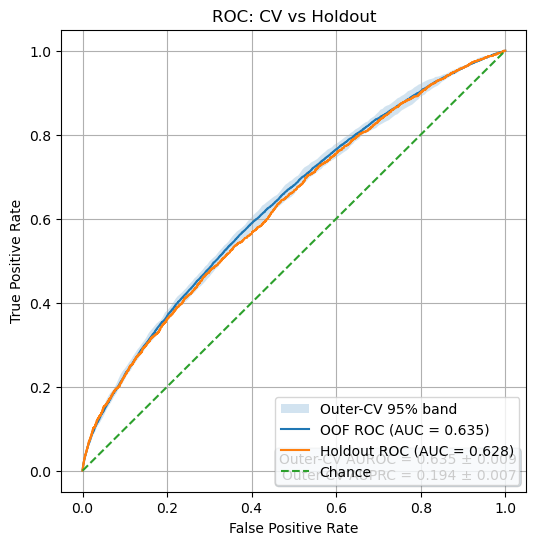

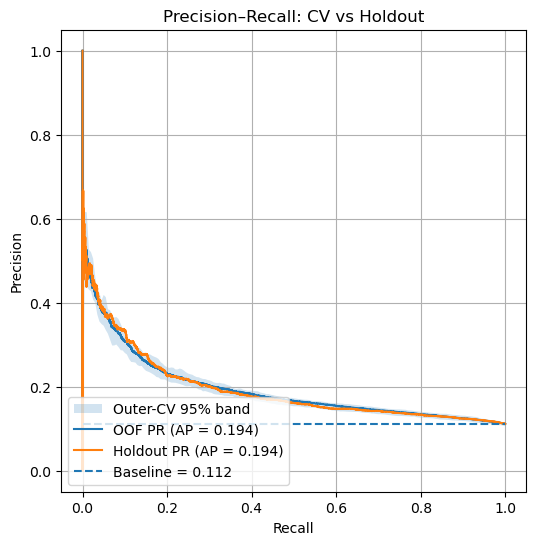

In [7]:
# OOF curves
fpr_oof, tpr_oof, _ = roc_curve(y, oof_pred)
auc_oof = auc(fpr_oof, tpr_oof)
prec_oof, rec_oof, _ = precision_recall_curve(y, oof_pred)
ap_oof = average_precision_score(y, oof_pred)

# Make outer-CV ribbons by interpolating each fold onto a common grid
fpr_grid = np.linspace(0, 1, 201)
tprs = np.vstack([np.interp(fpr_grid, f, t) for f, t in zip(fpr_list, tpr_list)])
tpr_lo, tpr_hi = np.percentile(tprs, [2.5, 97.5], axis=0)

rec_grid = np.linspace(0, 1, 201)
# Reverse (rec,prec) to be monotone for interp
precs = np.vstack([np.interp(rec_grid, r[::-1], p[::-1], left=1, right=p.min())
                   for p, r in zip(prec_list, rec_list)])
prec_lo, prec_hi = np.percentile(precs, [2.5, 97.5], axis=0)

# Holdout curves
y_test = y.iloc[test_idx]
p_test = proba
fpr_hold, tpr_hold, _ = roc_curve(y_test, p_test)
auc_hold = auc(fpr_hold, tpr_hold)
prec_hold, rec_hold, _ = precision_recall_curve(y_test, p_test)
ap_hold = average_precision_score(y_test, p_test)

# ROC plot
plt.figure(figsize=(6,6))
plt.fill_between(fpr_grid, tpr_lo, tpr_hi, alpha=0.2, label="Outer-CV 95% band")
plt.plot(fpr_oof, tpr_oof, label=f"OOF ROC (AUC = {auc_oof:.3f})")
plt.plot(fpr_hold, tpr_hold, label=f"Holdout ROC (AUC = {auc_hold:.3f})")
plt.plot([0,1],[0,1],'--',label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC: CV vs Holdout")
plt.legend(loc="lower right"); plt.grid(True)

# Annotate mean±sd
plt.text(0.98, 0.02,
         f"Outer-CV AUROC = {np.mean(outer_auroc):.3f} ± {np.std(outer_auroc):.3f}\n"
         f"Outer-CV AUPRC = {np.mean(outer_ap):.3f} ± {np.std(outer_ap):.3f}",
         transform=plt.gca().transAxes, ha="right", va="bottom",
         bbox=dict(boxstyle="round", alpha=0.15))
plt.show()

# PR plot
plt.figure(figsize=(6,6))
plt.fill_between(rec_grid, prec_lo, prec_hi, alpha=0.2, label="Outer-CV 95% band")
plt.plot(rec_oof, prec_oof, label=f"OOF PR (AP = {ap_oof:.3f})")
plt.plot(rec_hold, prec_hold, label=f"Holdout PR (AP = {ap_hold:.3f})")
plt.hlines(y_test.mean(), 0, 1, linestyles='--', label=f'Baseline = {y_test.mean():.3f}')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall: CV vs Holdout")
plt.legend(loc="lower left"); plt.grid(True); plt.show()

In [8]:
np.save("y.npy", y.to_numpy())
np.save("groups.npy", groups.to_numpy())
np.save("oof_pred.npy", oof_pred)
np.save("fold_id.npy",  fold_id)
np.save("fold_auroc.npy", np.array(outer_auroc))
np.save("fold_auprc.npy", np.array(outer_ap))
np.save("test_idx.npy",  test_idx)
np.save("holdout_proba.npy", proba)
np.save("fpr_grid.npy", fpr_grid); np.save("tpr_lo.npy", tpr_lo); np.save("tpr_hi.npy", tpr_hi)
np.save("rec_grid.npy", rec_grid); np.save("prec_lo.npy", prec_lo); np.save("prec_hi.npy", prec_hi)
np.save("best_Cs.npy", np.array(best_Cs))

from joblib import dump
dump(best_model, "final_pipeline.joblib")

pd.DataFrame(search.cv_results_).to_csv("last_inner_cv_results.csv", index=False)


### Key takeaways

- Data leakage leads to overly optimistic performance estimates.
- Leakage can occur subtly through preprocessing, feature construction, or target encoding.
- Proper experimental design is as important as model choice.
- Preventing leakage is essential for trustworthy evaluation and deployment.